In [37]:
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [38]:
romeo_and_juliet_files = glob("../graphdata/romeo-and-juliet**")
romeo_and_juliet_files

['../graphdata/romeo-and-juliet_ce.nodes.csv',
 '../graphdata/romeo-and-juliet_ce-group-w.edges.csv',
 '../graphdata/romeo-and-juliet_ce-group-mw.edges.csv',
 '../graphdata/romeo-and-juliet_ce-scene-w.edges.csv',
 '../graphdata/romeo-and-juliet_ce-scene-mw.edges.csv',
 '../graphdata/romeo-and-juliet_se-speech-mwd.edges.csv',
 '../graphdata/romeo-and-juliet_se-speech-wd.edges.csv',
 '../graphdata/romeo-and-juliet_se-group-w.edges.csv',
 '../graphdata/romeo-and-juliet_se-speech.nodes.csv',
 '../graphdata/romeo-and-juliet_se-scene-w.edges.csv',
 '../graphdata/romeo-and-juliet_se-group.nodes.csv',
 '../graphdata/romeo-and-juliet_se-scene.nodes.csv']

In [3]:
def prettify_identifier(identifier):
    return identifier.replace("#","").split("_")[0]

In [4]:
nodes_ce = pd.read_csv('../graphdata/romeo-and-juliet_ce.nodes.csv')
nodes_ce.node = nodes_ce.node.map(prettify_identifier)
nodes_ce = nodes_ce.query("not node.str.isupper()")

edges_ce_scene_mw = pd.read_csv('../graphdata/romeo-and-juliet_ce-scene-mw.edges.csv')
edges_ce_scene_mw.node1 = edges_ce_scene_mw.node1.map(prettify_identifier)
edges_ce_scene_mw.node2 = edges_ce_scene_mw.node2.map(prettify_identifier)
edges_ce_scene_mw = edges_ce_scene_mw.query("not node1.str.isupper() and not node2.str.isupper()")

edges_ce_group_mw = pd.read_csv('../graphdata/romeo-and-juliet_ce-group-mw.edges.csv')
edges_ce_group_mw.node1 = edges_ce_group_mw.node1.map(prettify_identifier)
edges_ce_group_mw.node2 = edges_ce_group_mw.node2.map(prettify_identifier)
edges_ce_group_mw = edges_ce_group_mw.query("not node1.str.isupper() and not node2.str.isupper()")

In [5]:
edges_ce_group_mw_agg = edges_ce_group_mw.groupby(["node1","node2"]).agg(dict(n_lines=sum)).reset_index()
edges_ce_group_mw_agg

,node1,node2,n_lines
0,Benvolio,Boy,262
1,Benvolio,Capulet,213
2,Benvolio,Cousin,124
3,Benvolio,Juliet,124
4,Benvolio,LadyCapulet,213
...,...,...,...
118,Tybalt,Montague,86
119,Tybalt,Nurse,86
120,Tybalt,Petruchio,57
121,Tybalt,PrinceEscalus,82


In [6]:
edges_ce_scene_mw_agg = edges_ce_scene_mw.groupby(["node1","node2"]).agg(dict(n_lines=sum)).reset_index()
edges_ce_scene_mw_agg

,node1,node2,n_lines
0,Apothecary,SERVANTS.MONTAGUE.Balthasar,91
1,Benvolio,Boy,282
2,Benvolio,Capulet,723
3,Benvolio,Cousin,161
4,Benvolio,Juliet,161
...,...,...,...
135,Tybalt,Cousin,161
136,Tybalt,Juliet,161
137,Tybalt,Mercutio,368
138,Tybalt,Nurse,161


In [7]:
G_ce_group_mw = nx.Graph()
G_ce_group_mw.add_nodes_from(nodes_ce.node)
G_ce_group_mw.add_weighted_edges_from(list(zip(edges_ce_group_mw_agg.node1,edges_ce_group_mw_agg.node2, edges_ce_group_mw_agg.n_lines)))

G_ce_scene_mw = nx.Graph()
G_ce_scene_mw.add_nodes_from(nodes_ce.node)
G_ce_scene_mw.add_weighted_edges_from(list(zip(edges_ce_scene_mw_agg.node1,edges_ce_scene_mw_agg.node2, edges_ce_scene_mw_agg.n_lines)))

In [8]:
len(G_ce_scene_mw), len(G_ce_group_mw)

(23, 23)

In [9]:
df_diff = pd.DataFrame(sorted(G_ce_scene_mw.edges(data="weight")), columns=["node1","node2","n_lines_scene"]).set_index(["node1","node2"])
df_diff["n_lines_group"] = 0
for n1,n2,w in G_ce_group_mw.edges(data="weight"):
    df_diff.at[(n1,n2),"n_lines_group"] = w

In [10]:
df_diff["n_lines_difference"] = df_diff.n_lines_scene - df_diff.n_lines_group

In [11]:
df_diff = df_diff.query("n_lines_difference != 0")

In [12]:
nodes_ce["color"] = "silver" # TODO color by faction 

In [13]:
import matplotlib.cm as cm

In [14]:
edge_widths_scene = [w/150 for u,v,w in G_ce_scene_mw.edges(data="weight")]
edge_widths_group = [w/150 for u,v,w in G_ce_group_mw.edges(data="weight")]
edge_widths_difference = [df_diff.at[(u,v),"n_lines_difference"]/150 for u,v in G_ce_scene_mw.edges()]

In [15]:
vmin = min(min(edge_widths_group), min(edge_widths_scene), min(edge_widths_difference))
vmax = max(max(edge_widths_group), max(edge_widths_scene), max(edge_widths_difference))

In [16]:
df_diff.sort_values("n_lines_difference", ascending=False)

,,n_lines_scene,n_lines_group,n_lines_difference
node1,node2,,,
Capulet,Romeo,1299,249,1050
LadyCapulet,Romeo,1191,249,942
Capulet,LadyCapulet,1461,588,873
Montague,Romeo,775,110,665
PrinceEscalus,Romeo,775,127,648
...,...,...,...,...
Paris,SERVANTS.MONTAGUE.Balthasar,321,300,21
Boy,Mercutio,282,262,20
Benvolio,Boy,282,262,20


In [17]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Palatino"
plt.rcParams["text.usetex"] = True
plt.rcParams['pdf.fonttype'] = 42

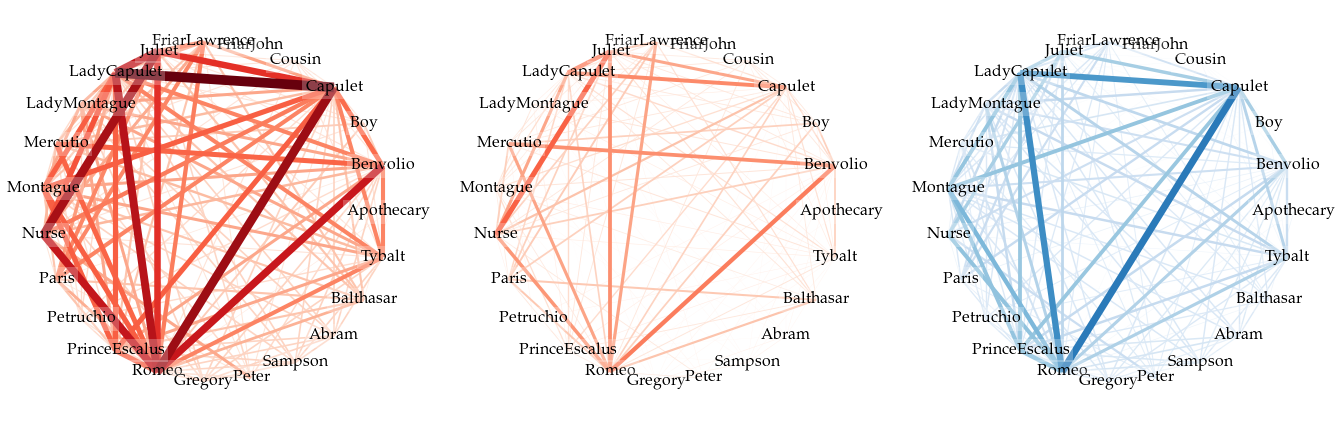

In [18]:
height = 6
font_size = 16
fig, ax = plt.subplots(1,3,figsize=(height*3+1,height))
pos = nx.circular_layout(G_ce_group_mw)

#nx.draw_networkx_nodes(G_ce_scene_mw, pos=pos, ax=ax[0], node_color="silver")
nx.draw_networkx_edges(G_ce_scene_mw, pos=pos, ax=ax[0], 
                       edgelist=[(u,v) for u,v,w in sorted(G_ce_scene_mw.edges(data="weight"),key=lambda tup:tup[-1])],
                       width=sorted(edge_widths_scene), 
                       edge_cmap=cm.Reds, edge_vmin=vmin, edge_vmax=vmax, edge_color=sorted(edge_widths_scene),
                      )
nx.draw_networkx_labels(G_ce_scene_mw, labels={n:n.split(".")[-1] for n in G_ce_group_mw.nodes()}, pos=pos, ax=ax[0],
                        font_family="serif", font_size=font_size, clip_on=False, bbox=dict(fc="white",lw=0, alpha=0.25)
                       )

#nx.draw_networkx_nodes(G_ce_scene_mw, pos=pos, ax=ax[1], node_color="silver")
nx.draw_networkx_edges(G_ce_group_mw, pos=pos, ax=ax[1], width=sorted(edge_widths_group), 
                       edgelist=[(u,v) for u,v,w in sorted(G_ce_group_mw.edges(data="weight"),key=lambda tup:tup[-1])],
                       edge_cmap=cm.Reds, edge_vmin=vmin, edge_vmax=vmax, edge_color=sorted(edge_widths_group),
                      )
nx.draw_networkx_labels(G_ce_group_mw, labels={n:n.split(".")[-1] for n in G_ce_group_mw.nodes()}, pos=pos, ax=ax[1],
                        font_family="serif", font_size=font_size, clip_on=False, bbox=dict(fc="white",lw=0, alpha=0.25)
                       )


#nx.draw_networkx_nodes(G_ce_scene_mw, pos=pos, ax=ax[2], node_color="silver")
nx.draw_networkx_edges(G_ce_scene_mw, pos=pos, ax=ax[2], 
                       edgelist=df_diff.sort_values("n_lines_difference", ascending=True).index,
                       width=sorted(edge_widths_difference),
                       edge_cmap=cm.Blues, edge_vmin=vmin, edge_vmax=vmax, edge_color=sorted(edge_widths_difference),
                      )
nx.draw_networkx_labels(G_ce_scene_mw, labels={n:n.split(".")[-1] for n in G_ce_scene_mw.nodes()}, pos=pos, ax=ax[2],
                        font_family="serif", font_size=font_size, clip_on=False, bbox=dict(fc="white",lw=0, alpha=0.25)
                       )

for idx in range(3):
    ax[idx].axis("off")
plt.tight_layout()
plt.savefig("romeo_and_juliet_ce-differences.pdf", transparent=True, bbox_inches="tight")

In [19]:
act_3_scene_5_ce = edges_ce_group_mw.query("act == 3 and scene == 5").groupby(["node1","node2"]).agg(dict(n_lines=sum))

In [20]:
act_3_scene_5_ce_edges = list((*idx,row["n_lines"]) for idx, row in act_3_scene_5_ce.iterrows())

In [21]:
G_3_5 = nx.Graph()
G_3_5.add_weighted_edges_from(act_3_scene_5_ce_edges)

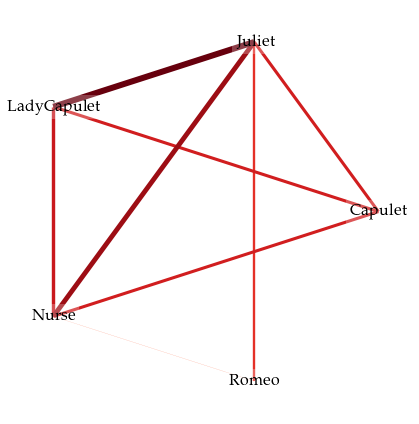

In [22]:
edge_widths_3_5 = [w/25 for u,v,w in sorted(G_3_5.edges(data="weight"),key=lambda tup:tup[-1])]
min35 = min(edge_widths_3_5)
max35 = max(edge_widths_3_5)
height = 6
font_size = 16
fig, ax = plt.subplots(1,1,figsize=(height,height))
pos = nx.circular_layout(G_3_5)
#nx.draw_networkx_nodes(G_3_5, pos=pos 
                       #nodelist=["Capulet","Juliet","LadyCapulet","Nurse","Romeo"], 
                       #node_color=["#984ea3","#e41a1c","#984ea3","silver","#e41a1c"])
nx.draw_networkx_labels(G_3_5, pos=pos, clip_on=False, font_size=font_size,bbox=dict(fc="white",lw=0, alpha=0.25))
nx.draw_networkx_edges(G_3_5, pos=pos, width=edge_widths_3_5,
                       edgelist=[(u,v) for u,v,w in sorted(G_3_5.edges(data="weight"),key=lambda tup:tup[-1])],
                       edge_cmap=cm.Reds, edge_vmin=min35-5, edge_vmax=max35, edge_color=edge_widths_3_5
                      )
plt.axis("off")
plt.tight_layout()
plt.savefig("romeo_and_juliet_ce-3_5.pdf", transparent=True, bbox_inches="tight")

### Star expansions

In [23]:
se_scene_nodes = pd.read_csv('../graphdata/romeo-and-juliet_se-scene.nodes.csv')
se_scene_nodes.node = se_scene_nodes.node.map(prettify_identifier)
se_scene_edges = pd.read_csv('../graphdata/romeo-and-juliet_se-scene-w.edges.csv')
se_scene_edges.node1 = se_scene_edges.node1.map(prettify_identifier)
se_scene_edges.node2 = se_scene_edges.node2.astype(str)
se_scene_edges = se_scene_edges.query("not node1.str.isupper()")

se_group_nodes = pd.read_csv('../graphdata/romeo-and-juliet_se-group.nodes.csv')
se_group_nodes.node = se_group_nodes.node.map(prettify_identifier)
se_group_edges = pd.read_csv('../graphdata/romeo-and-juliet_se-group-w.edges.csv')
se_group_edges.node1 = se_group_edges.node1.map(prettify_identifier)
se_group_edges.node2 = se_group_edges.node2.astype(str)
se_group_edges = se_group_edges.query("not node1.str.isupper()")

In [25]:
se_scene_act3_edges = se_scene_edges.query("node2.str.startswith('3')")
se_group_act3_edges = se_group_edges.query("node2.str.startswith('3')")

In [26]:
G_act3 = nx.Graph()
G_act3.add_nodes_from(se_scene_act3_edges.node1, node_type="character")
G_act3.add_nodes_from(se_scene_act3_edges.node2, node_type="text_unit")
G_act3.add_weighted_edges_from(list(zip(se_scene_act3_edges.node1, se_scene_act3_edges.node2, se_scene_act3_edges.n_lines)))

In [27]:
characters_act3 = sorted(se_scene_act3_edges.node1.unique())
scene_play_parts_act3 = sorted(se_scene_act3_edges.node2.unique())

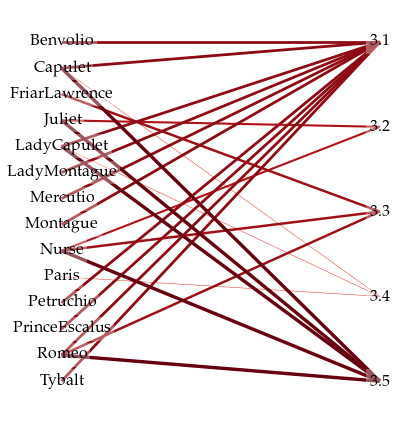

In [28]:
pos = {**{k:(0,1-idx/(len(characters_act3)-1)) for idx,k in enumerate(characters_act3)}, 
       **{k:(1,1-idx/(len(scene_play_parts_act3)-1)) for idx,k in enumerate(scene_play_parts_act3)}}
font_size = 16
fig, ax = plt.subplots(1,1,figsize=(6,6))
#nx.draw_networkx_nodes(G_act3, pos=pos, node_color="white")
act3_edgewidths = [w/75 for u,v,w in sorted(G_act3.edges(data="weight"),key=lambda tup:tup[-1])]
min3 = min(act3_edgewidths)
max3 = max(act3_edgewidths)
nx.draw_networkx_edges(G_act3, pos=pos, width=act3_edgewidths, 
                       edgelist=[(u,v) for u,v,w in sorted(G_act3.edges(data="weight"),key=lambda tup:tup[-1])],
                       edge_cmap=cm.Reds, edge_vmin=min3-5, edge_vmax=max3, edge_color=act3_edgewidths)
nx.draw_networkx_labels(G_act3, pos=pos, clip_on=False, font_size=font_size, bbox=dict(fc="white",lw=0, alpha=0.33),
                       labels={k:k.replace("3.0","3.") for k in G_act3.nodes()}
                       )
plt.axis("off")
plt.tight_layout()
plt.savefig("romeo_and_juliet_se-scene_act-3.pdf", transparent=True, bbox_inches="tight")

In [29]:
G_act3_group = nx.Graph()
G_act3_group.add_nodes_from(se_group_act3_edges.node1, node_type="character")
G_act3_group.add_nodes_from(se_group_act3_edges.node2, node_type="text_unit")
G_act3_group.add_weighted_edges_from(list(zip(se_group_act3_edges.node1, se_group_act3_edges.node2, se_group_act3_edges.n_lines)))

In [30]:
characters_act3_group = sorted(se_group_act3_edges.node1.unique())
group_play_parts_act3 = sorted(se_group_act3_edges.node2.unique())

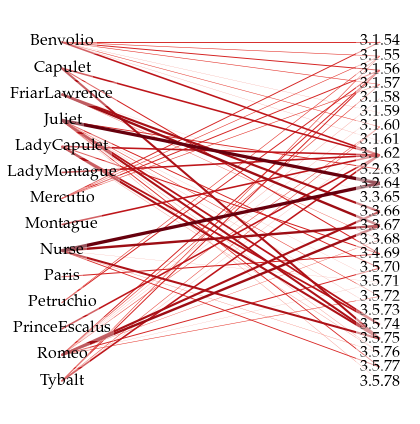

In [31]:
pos = {**{k:(0,1-idx/(len(characters_act3_group)-1)) for idx,k in enumerate(characters_act3_group)}, 
       **{k:(1,1-idx/(len(group_play_parts_act3)-1)) for idx,k in enumerate(group_play_parts_act3)}}
font_size = 16
fig, ax = plt.subplots(1,1,figsize=(6,6))
act3_group_edgewidths = [w/(75/2) for u,v,w in sorted(G_act3_group.edges(data="weight"),key=lambda tup:tup[-1])]
min3 = min(act3_group_edgewidths)
max3 = max(act3_group_edgewidths)
nx.draw_networkx_edges(G_act3_group, pos=pos, width=act3_group_edgewidths, 
                       edgelist=[(u,v) for u,v,w in sorted(G_act3_group.edges(data="weight"),key=lambda tup:tup[-1])],
                       edge_cmap=cm.Reds, edge_vmin=min3-5, edge_vmax=max3, edge_color=act3_group_edgewidths)
nx.draw_networkx_labels(G_act3_group, labels={k:k.replace("00","").replace("3.0","3.") for k in G_act3_group.nodes()}, pos=pos, clip_on=False, font_size=font_size, 
                        bbox=dict(fc="white",lw=0, alpha=0.33)
                       )
plt.axis("off")
plt.tight_layout()
plt.savefig("romeo_and_juliet_se-group_act-3.pdf", transparent=True, bbox_inches="tight")

In [32]:
se_group_3_5_edges = se_group_act3_edges.query("node2.str.startswith('3.05')")
se_group_3_5_edges.tail()

,node1,node2,n_lines,n_tokens
345,LadyCapulet,3.05.0076,8,68
346,Nurse,3.05.0076,8,68
348,Juliet,3.05.0077,32,241
349,Nurse,3.05.0077,32,241
351,Juliet,3.05.0078,8,63


In [33]:
characters_3_5_group = sorted(se_group_3_5_edges.node1.unique())
group_play_parts_3_5 = sorted(se_group_3_5_edges.node2.unique())

In [34]:
G_3_5_se = nx.Graph()
G_3_5_se.add_weighted_edges_from(list(zip(se_group_3_5_edges.node1, se_group_3_5_edges.node2, se_group_3_5_edges.n_lines)))

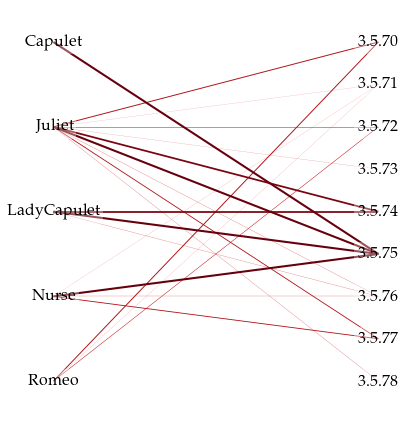

In [35]:
pos = {**{k:(0,1-idx/(len(characters_3_5_group)-1)) for idx,k in enumerate(characters_3_5_group)}, 
       **{k:(1,1-idx/(len(group_play_parts_3_5)-1)) for idx,k in enumerate(group_play_parts_3_5)}}
font_size = 16
fig, ax = plt.subplots(1,1,figsize=(6,6))
act3_5_group_edgewidths = [w/(75/2) for u,v,w in sorted(G_3_5_se.edges(data="weight"),key=lambda tup:tup[-1])]
min3 = min(act3_5_group_edgewidths)
max3 = max(act3_5_group_edgewidths)
nx.draw_networkx_edges(G_3_5_se, pos=pos, width=act3_5_group_edgewidths, 
                       edgelist=[(u,v) for u,v,w in sorted(G_3_5_se.edges(data="weight"),key=lambda tup:tup[-1])],
                       edge_cmap=cm.Reds, edge_vmin=min3-5, edge_vmax=max3, edge_color=act3_5_group_edgewidths)
nx.draw_networkx_labels(G_3_5_se, labels={k:k.replace("00","").replace("3.0","3.") for k in G_3_5_se.nodes()}, 
                        pos=pos, clip_on=False, font_size=font_size, 
                        bbox=dict(fc="white",lw=0, alpha=0.33)
                       )
plt.axis("off")
plt.tight_layout()
plt.savefig("romeo_and_juliet_se-group_3-5.pdf", transparent=True, bbox_inches="tight")

## Crap Code Alarm!

### Star expansion, speech level, Act III

In [141]:
speech_nodes = pd.read_csv('../graphdata/romeo-and-juliet_se-speech.nodes.csv')
speech_nodes.node = speech_nodes.node.map(prettify_identifier)

In [142]:
speech_edges_wd = pd.read_csv('../graphdata/romeo-and-juliet_se-speech-wd.edges.csv')
speech_edges_wd.source = speech_edges_wd.source.map(prettify_identifier)
speech_edges_wd.target = speech_edges_wd.target.map(prettify_identifier)

In [143]:
speech_edges_wd_3_5 = speech_edges_wd.query("source.str.startswith('3.') or target.str.startswith('3.')").copy()
speech_edges_wd_3_5 = speech_edges_wd_3_5.query("not source.str.isupper() and not target.str.isupper()").copy()
speech_edges_wd_3_5.source = speech_edges_wd_3_5.source.map(lambda x: x if x.startswith("3") else f"{x}-O")
speech_edges_wd_3_5.target = speech_edges_wd_3_5.target.map(lambda x: x if x.startswith("3") else f"{x}-I")

In [144]:
speech_G = nx.DiGraph()
speech_G.add_nodes_from({n for n in list(speech_edges_wd_3_5.source) + list(speech_edges_wd_3_5.target)})
speech_G.add_weighted_edges_from(list(zip(speech_edges_wd_3_5.source,speech_edges_wd_3_5.target, speech_edges_wd_3_5.n_lines)))
print(speech_G)

DiGraph with 52 nodes and 113 edges


In [145]:
in_characters = sorted([n for n in speech_G.nodes if n.endswith("I")])
out_characters = sorted([n for n in speech_G.nodes if n.endswith("O")])
text_units = sorted([n for n in speech_G.nodes if n.startswith("3")])

In [146]:
pos = {**{k:(0,1-idx/(len(out_characters)-1)) for idx,k in enumerate(out_characters)}, 
       **{k:(1,1-idx/(len(text_units)-1)) for idx,k in enumerate(text_units)},
       **{k:(2,1-idx/(len(in_characters)-1)) for idx,k in enumerate(in_characters)}
      }

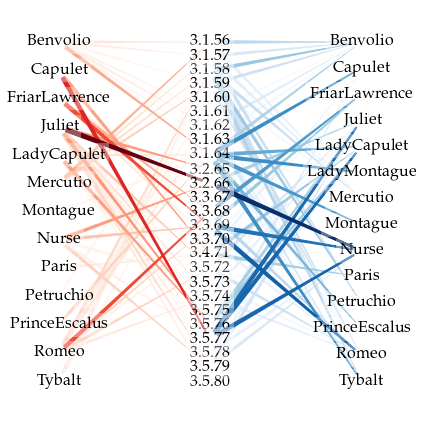

In [147]:
font_size = 16
fig, ax = plt.subplots(1,1,figsize=(6,6))
speech_edgewidths = [w/(75/2) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1])]
speech_edgewidths_out = [w/(75/2) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if u.endswith("O")]
speech_edgewidths_in = [w/(75/2) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if v.endswith("I")]
min3 = min(speech_edgewidths)
max3 = max(speech_edgewidths)
nx.draw_networkx_edges(speech_G, pos=pos, width=speech_edgewidths_out, 
                       edgelist=[(u,v) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if u.endswith("O")],
                       edge_cmap=cm.Reds, edge_vmin=min3, edge_vmax=max3, edge_color=speech_edgewidths_out,
                       arrows=True, arrowstyle="wedge"
                      )
nx.draw_networkx_edges(speech_G, pos=pos, width=speech_edgewidths_in, 
                       edgelist=[(u,v) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if v.endswith("I")],
                       edge_cmap=cm.Blues, edge_vmin=min3, edge_vmax=max3, edge_color=speech_edgewidths_in,
                       arrows=True, arrowstyle="wedge"
                      )
nx.draw_networkx_labels(speech_G, labels={k:k.replace("00","").replace("3.0","3.").split("-")[0] for k in speech_G.nodes()}, 
                        pos=pos, clip_on=False, font_size=font_size, 
                        bbox=dict(fc="white",lw=0, alpha=0.33)
                       )
plt.axis("off")
plt.tight_layout()
plt.savefig("romeo_and_juliet_se-speech_3.pdf", transparent=True, bbox_inches="tight")

### Star expansion, speech level, Act III, Scene V

In [136]:
speech_edges_wd_3_5 = speech_edges_wd.query("source.str.startswith('3.05') or target.str.startswith('3.05')").copy()
speech_edges_wd_3_5 = speech_edges_wd_3_5.query("not source.str.isupper() and not target.str.isupper()").copy()
speech_edges_wd_3_5.source = speech_edges_wd_3_5.source.map(lambda x: x if x.startswith("3") else f"{x}-O")
speech_edges_wd_3_5.target = speech_edges_wd_3_5.target.map(lambda x: x if x.startswith("3") else f"{x}-I")

In [137]:
speech_G = nx.DiGraph()
speech_G.add_nodes_from({n for n in list(speech_edges_wd_3_5.source) + list(speech_edges_wd_3_5.target)})
speech_G.add_weighted_edges_from(list(zip(speech_edges_wd_3_5.source,speech_edges_wd_3_5.target, speech_edges_wd_3_5.n_lines)))
print(speech_G)

DiGraph with 19 nodes and 36 edges


In [138]:
in_characters = sorted([n for n in speech_G.nodes if n.endswith("I")])
out_characters = sorted([n for n in speech_G.nodes if n.endswith("O")])
text_units = sorted([n for n in speech_G.nodes if n.startswith("3")])

In [139]:
pos = {**{k:(0,1-idx/(len(out_characters)-1)) for idx,k in enumerate(out_characters)}, 
       **{k:(1,1-idx/(len(text_units)-1)) for idx,k in enumerate(text_units)},
       **{k:(2,1-idx/(len(in_characters)-1)) for idx,k in enumerate(in_characters)}
      }

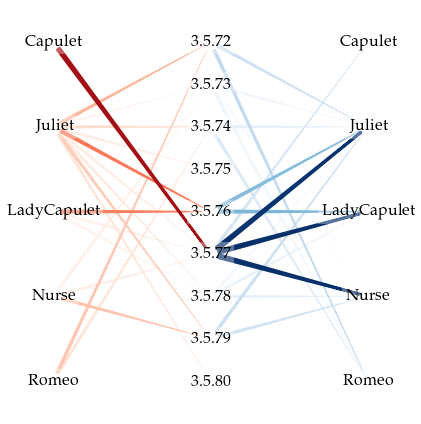

In [140]:
font_size = 16
fig, ax = plt.subplots(1,1,figsize=(6,6))
speech_edgewidths = [w/(50/2) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1])]
speech_edgewidths_out = [w/(50/2) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if u.endswith("O")]
speech_edgewidths_in = [w/(50/2) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if v.endswith("I")]
min3 = min(speech_edgewidths)
max3 = max(speech_edgewidths)
nx.draw_networkx_edges(speech_G, pos=pos, width=speech_edgewidths_out, 
                       edgelist=[(u,v) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if u.endswith("O")],
                       edge_cmap=cm.Reds, edge_vmin=min3, edge_vmax=max3, edge_color=speech_edgewidths_out,
                       arrows=True, arrowstyle="wedge"
                      )
nx.draw_networkx_edges(speech_G, pos=pos, width=speech_edgewidths_in, 
                       edgelist=[(u,v) for u,v,w in sorted(speech_G.edges(data="weight"),key=lambda tup:tup[-1]) if v.endswith("I")],
                       edge_cmap=cm.Blues, edge_vmin=min3, edge_vmax=max3, edge_color=speech_edgewidths_in,
                       arrows=True, arrowstyle="wedge"
                      )
nx.draw_networkx_labels(speech_G, labels={k:k.replace("00","").replace("3.0","3.").split("-")[0] for k in speech_G.nodes()}, 
                        pos=pos, clip_on=False, font_size=font_size, 
                        bbox=dict(fc="white",lw=0, alpha=0.33)
                       )
plt.axis("off")
plt.tight_layout()
plt.savefig("romeo_and_juliet_se-speech_3-5.pdf", transparent=True, bbox_inches="tight")